In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Loading the .mat file
from scipy.io import loadmat
data = loadmat("Indian_pines_corrected.mat")
print(data.keys()) 

dict_keys(['__header__', '__version__', '__globals__', 'indian_pines_corrected'])


In [2]:
# Extracting the hyperspectral cube
cube = data['indian_pines_corrected']   

Log Transformation

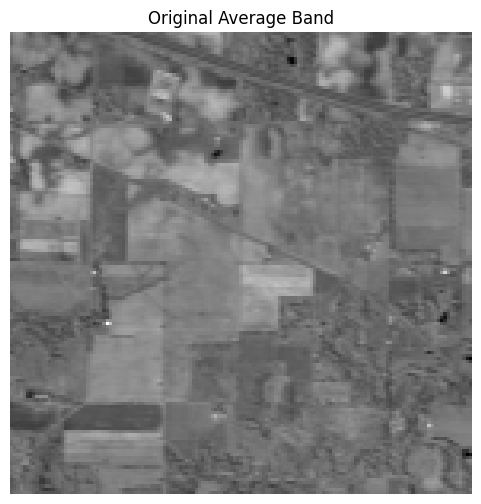

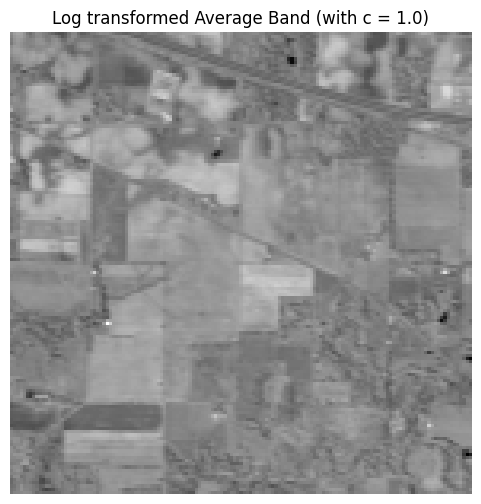

In [4]:
# Log Transformation Function:
def log_transform(image, c = 1.0): 

    # Convert image to float
    image = image.astype(np.float32)

    # Normalizing the image to [0, 1]
    R = (image - np.min(image))/(np.max(image) - np.min(image) + 1e-12)

    # Applying log transformation S = log(1+R)
    S = c*np.log1p(R)  

    # normalizing the transformed image to [0,1]
    S_norm = (S - np.min(S))/(np.max(S) - np.min(S) + 1e-12)

    return S_norm

# Applying it to average of all bands
avg_image = np.mean(cube, axis = 2) 
log_avg = log_transform(avg_image, c = 1.0)

plt.figure(figsize=(6,6))
plt.title("Original Average Band")
plt.imshow(avg_image, cmap="grey")
plt.axis('off')

plt.figure(figsize=(6,6))
plt.title("Log transformed Average Band (with c = 1.0)")
plt.imshow(log_avg, cmap='grey')
plt.axis('off')

plt.show()


Gamma Correction

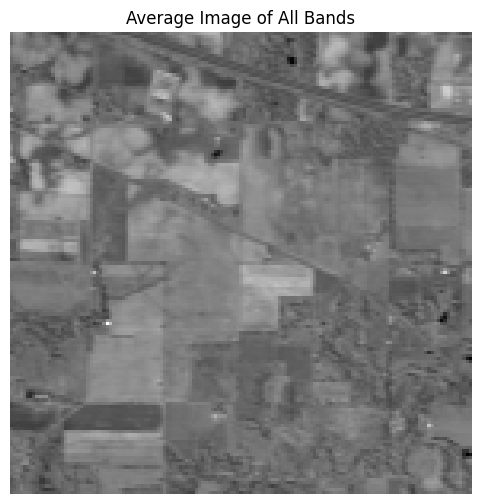

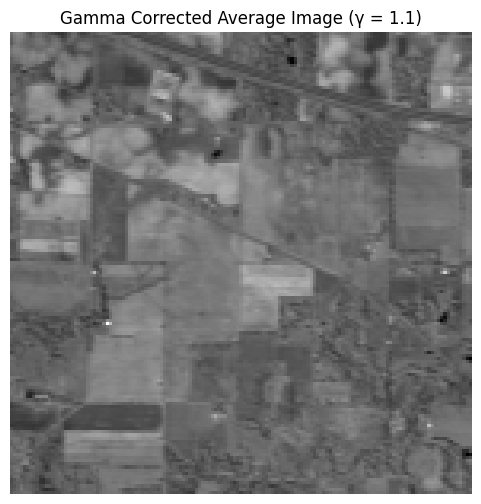

In [6]:
def gamma_correction(image, gamma, c = 1.0):

    # Converting to float
    image = image.astype(np.float32)

    # Normalizing the input pixel values
    R = (image - np.min(image))/(np.max(image) - np.min(image) + 1e-12)

    # Applying gamma correction
    S = c*(R**gamma)

    # Normalizing the output pixel values
    S_norm = (S - np.min(S))/(np.max(S) - np.min(S) + 1e-12)

    return S_norm

#applying it to average of all bands
avg_img = np.mean(cube, axis=2)
gamma_value = 1.1
gamma_avg = gamma_correction(avg_img, gamma_value, c = 1.0)

plt.figure(figsize=(6,6))
plt.title("Average Image of All Bands")
plt.imshow(avg_img, cmap='gray')
plt.axis('off')

plt.figure(figsize=(6,6))
plt.title(f"Gamma Corrected Average Image (γ = {gamma_value})")
plt.imshow(gamma_avg, cmap='gray')
plt.axis('off')

plt.show()

Contrast Stretching

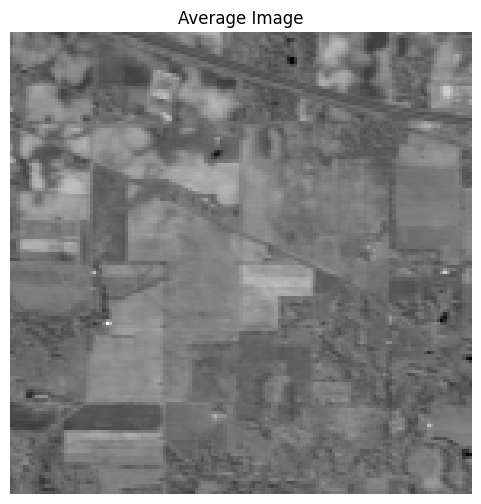

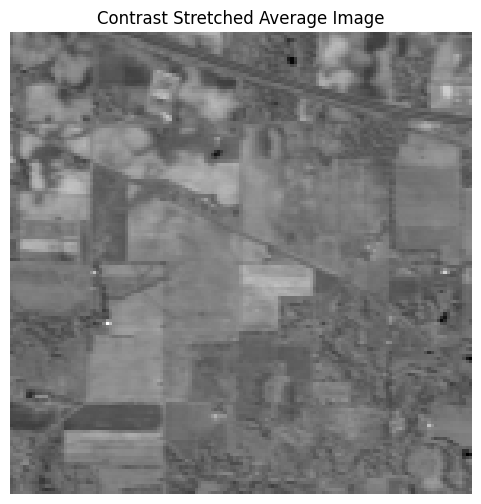

In [ ]:
def contrast_stretch(image):
    
    # converting to float
    image = image.astype(np.float32)

    R_min = np.min(image)
    R_max = np.max(image)

    # Stretching formula
    S = (image - R_min)/(R_max - R_min + 1e-12)  

    return S

#Applying it to average of all bands

avg_image = np.mean(cube, axis=2)
cs_avg = contrast_stretch(avg_image)
plt.figure(figsize=(6,6))
plt.title("Average Image")
plt.imshow(avg_image, cmap='gray')
plt.axis('off')

plt.figure(figsize=(6,6))
plt.title("Contrast Stretched Average Image")
plt.imshow(cs_avg, cmap='gray')
plt.axis('off')

plt.show()

Histogram Equalization

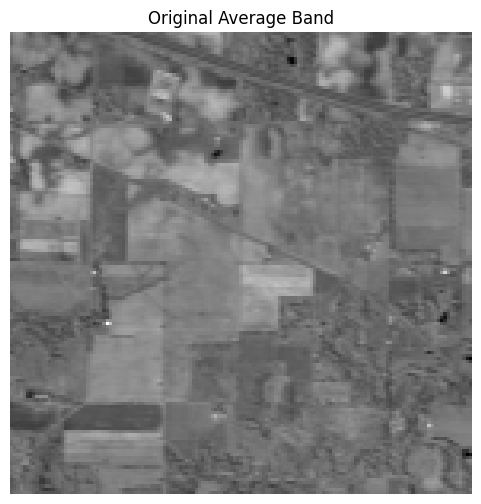

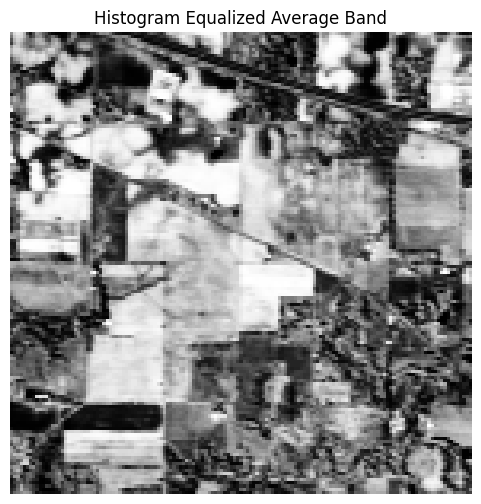

In [9]:
def histogram_equalization(image):

    # Converting to float
    image = image.astype(np.float32)

    # Normalize image to 0-255 range for HE
    img_norm = (image - image.min()) / (image.max() - image.min() + 1e-12)
    img_int = (img_norm*255).astype(np.uint8) 

    hist = np.zeros(256) 
    for value in img_int.flatten():  
        hist[value] += 1 
    # total pixels
    n = img_int.size

    # Computing pdf p(r_k) = n_k/n
    pdf = hist/n

    # Computing cdf
    cdf = np.cumsum(pdf) 

    # applying transformation s_k = (L-1)*c(r_k)
    s_k = np.round(cdf * 255).astype(np.uint8) # L = 256

    # map each pixel using s_k
    equalized = s_k[img_int]

    # normalizing the output pixel values
    equalized_norm = equalized.astype(np.float32) / 255.0

    return equalized_norm

#applying it to average of all bands
avg_image = np.mean(cube, axis=2)
he_avg = histogram_equalization(avg_image)

plt.figure(figsize=(6,6))
plt.title("Original Average Band")
plt.imshow(avg_image, cmap='gray')
plt.axis('off')

plt.figure(figsize=(6,6))
plt.title("Histogram Equalized Average Band")
plt.imshow(he_avg, cmap='gray')
plt.axis('off')

plt.show()

Convolution Filters

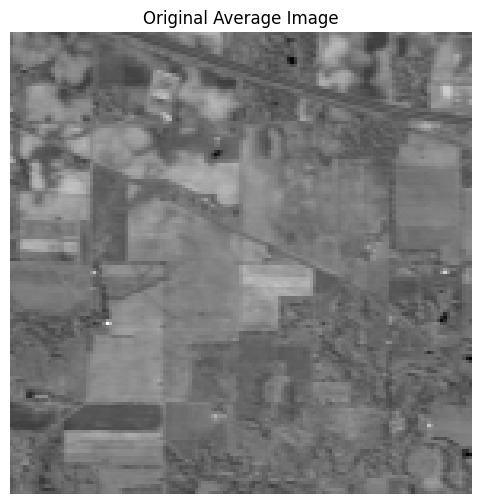

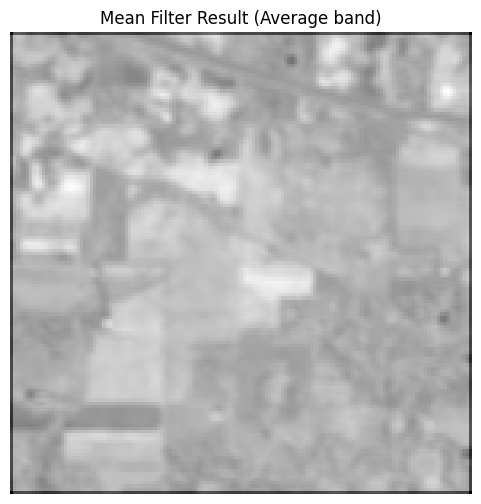

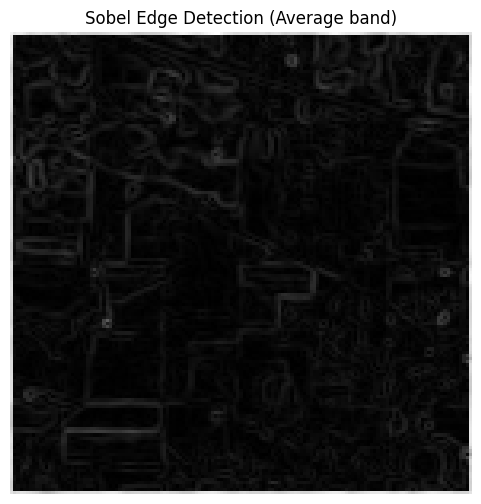

In [10]:
def convolve(image, kernel):
    image = image.astype(np.float32)

    #kernel dimensions
    k_h, k_w = kernel.shape
    pad_h = k_h//2
    pad_w = k_w//2

    #output image
    output = np.zeros_like(image)  

    # padding image to handle borders
    padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')

    #performing convolution manually
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded[i:i+k_h, j:j+k_w]
            output[i, j] = np.sum(region*kernel)

    return output

mean_kernel = np.ones((3,3), dtype=np.float32) / 9.0 #mean filter (3x3)

#horizontal sobel filter (to detect vertical edges)
sobel_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
], dtype=np.float32)

#vertical sobel filter (to detect horizontal edges)
sobel_y = np.array([
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]
], dtype=np.float32)

#applying it to average of all bands
avg_image = np.mean(cube, axis=2)

smoothed_avg = convolve(avg_image, mean_kernel)
edge_x_avg = convolve(avg_image, sobel_x)
edge_y_avg = convolve(avg_image, sobel_y)
edges_avg = np.sqrt(edge_x_avg**2 + edge_y_avg**2)

plt.figure(figsize=(6,6))
plt.title("Original Average Image")
plt.imshow(avg_image, cmap='gray')
plt.axis('off')

plt.figure(figsize=(6,6))
plt.title("Mean Filter Result (Average band)")
plt.imshow(smoothed_avg, cmap='gray')
plt.axis('off')

plt.figure(figsize=(6,6))
plt.title("Sobel Edge Detection (Average band)")
plt.imshow(edges_avg, cmap='gray')
plt.axis('off')

plt.show()